# Spatial Niche Networks and Connections

In [46]:
import os
import numpy as np
import pandas as pd
from typing import Union
from joblib import Parallel, delayed
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
from adjustText import adjust_text
import igraph as ig
import seaborn as sns

usage_threshold = 0
cond2 = None
n_bins = 1000
edge_threshold = "gt02"

In [2]:
def compute_pairwise_stats(usage: pd.DataFrame, usage_threshold: Union[int, float], cond1: str, save_path: str = None, file_prefix: str = None) -> pd.DataFrame:
    """
    Computes pairwise statistics for program interactions based on usage counts.

    For each pair of programs, calculates the number of samples where program_two is present or absent among those where program_one is present, using a specified usage threshold.

    Parameters
    ----------
    usage : pandas.DataFrame
        DataFrame with programs as columns and samples as rows, containing usage counts for each program per sample.
    usage_threshold : int or float
        Threshold for usage counts; a program is considered present in a sample if its count exceeds this value.
    cond1 : str
        Condition name or sample identifier to annotate results.
    save_path : str, optional
        Directory to save the output file. If None, results are not saved.
    file_prefix : str, optional
        Prefix for the output file name.

    Returns
    -------
    pandas.DataFrame
        DataFrame with pairwise statistics for each program pair, including:
        - group1: Condition/sample identifier.
        - n: Number of samples considered.
        - program_one: First program in the pair.
        - program_two: Second program in the pair.
        - <cond1>_P2pos: Number of samples where program_two is present (> threshold) among those where program_one is present.
        - <cond1>_P2neg: Number of samples where program_two is absent (<= threshold) among those where program_one is present.
        - Additional columns for enrichment values and thresholds if computed.
    """

    def pairwise(p1, p2):
        rows = cutoff.index[cutoff[p1] > usage_threshold]
        vals = cutoff.loc[rows, p2]
        pos = np.sum(vals > usage_threshold)
        neg = np.sum(vals <= usage_threshold)
        return {'group1': cond1, 
                'n': pos + neg,
                'program_one': p1, 
                'program_two': p2,
                f'{cond1}_P2pos': pos, 
                f'{cond1}_P2neg': neg}

    if save_path is not None:
        stats_fn = os.path.join(save_path, f"uthresh{usage_threshold}_{file_prefix}_Cell_Cell_Interaction_Enrichment.tsv")
        
        # Check if stats file already exists
        if os.path.exists(stats_fn):
            return pd.read_csv(stats_fn, sep='\t')
    
        # If not exists, compute pairwise statistics
        else:
            programs = usage.columns
            cutoff = usage

            # Parallel computation of pairwise statistics
            records = Parallel(n_jobs=-1)(delayed(pairwise)(p1, p2) for p1 in programs for p2 in programs)
            stats_df = pd.DataFrame.from_records(records)
            stats_df.to_csv(stats_fn, sep='\t', index=False)
            return stats_df
    else:
        # If save_path is None, compute pairwise statistics without saving
        programs = usage.columns
        cutoff = usage

        records = Parallel(n_jobs=-1)(delayed(pairwise)(p1, p2) for p1 in programs for p2 in programs)
        stats_df = pd.DataFrame.from_records(records)
        return stats_df


def generate_node_attributes(usage: pd.DataFrame, usage_threshold: Union[int, float], cond1: str) -> pd.DataFrame:
    """
    Generates node attributes for each program for use in network visualization.

    Calculates, for each program, the number and proportion of samples where usage exceeds the threshold, and whether the program is prevalent (>=100 samples above threshold).

    Parameters
    ----------
    usage : pandas.DataFrame
        DataFrame with programs as columns and samples as rows, containing usage counts for each program per sample.
    usage_threshold : int or float
        Threshold for usage counts; a program is considered present in a sample if its count exceeds this value.
    cond1 : str
        Condition name or sample identifier to annotate nodes.

    Returns
    -------
    pandas.DataFrame
        DataFrame with node attributes for each program, including:
        - sample_id: Identifier for the condition/sample.
        - total_spots: Total number of samples (rows) in the usage matrix.
        - program: Program name (column in usage).
        - num_samples_cps_gt_100: Indicator (1/0) if the number of samples with usage > threshold is at least 100.
        - cpp: Number of samples where usage > threshold for the program.
        - proportion: Fraction of samples where usage > threshold for the program.
    """

    total_spots = len(usage)
    programs = usage.columns

    # Calculate the number of samples with counts per sample (cps) greater than the threshold, the counts per program (cpp), and the proportion of samples with cps greater than the threshold
    node_summary = []
    for prog in programs:
        cps = (usage[prog] > usage_threshold).sum()
        node_summary.append({
            'sample_id': cond1,
            'total_spots': total_spots,
            'program': prog,
            'num_samples_cps_gt_100': int(cps >= 100),
            'cpp': cps,
            'proportion': cps / total_spots
        })

    node_summary = pd.DataFrame(node_summary)
    node_summary = (node_summary.drop_duplicates(subset=["sample_id", "program"]).loc[:, ["sample_id", "total_spots", "program", "num_samples_cps_gt_100", "cpp", "proportion"]])
    return node_summary


def build_network_graph(stats_df: pd.DataFrame, node_attrs: pd.DataFrame, cond1: str, n_bins: int) -> Union[nx.DiGraph, nx.DiGraph]:
    """
    Builds a directed NetworkX graph from pairwise statistics and node attributes.

    Adds nodes with attributes and edges between program pairs that meet the minimum bin threshold and are not self-loops. Edge weights are set by enrichment values.

    Parameters
    ----------
    stats_df : pandas.DataFrame
        DataFrame containing pairwise statistics for program pairs.
    node_attrs : pandas.DataFrame
        DataFrame containing node attributes for each program.
    cond1 : str
        Condition name for the nodes.
    n_bins : int
        Minimum number of bins (samples) for an edge to be included.

    Returns
    -------
    graph : networkx.DiGraph
        Full directed graph with all nodes and edges.
    graph_filtered : networkx.DiGraph
        Subgraph containing only nodes with at least one edge.
    """

    graph = nx.DiGraph()

    # Add nodes with attributes
    for row in node_attrs.itertuples(index=False):
        graph.add_node(row.program, 
                       num_samples_cps_gt_100=row.num_samples_cps_gt_100, 
                       name=row.program)

    # Only keep edges that meet the threshold
    for row in stats_df.itertuples(index=False):
        if row.n >= n_bins and row.program_one != row.program_two:
            w = getattr(row, f"{cond1}_val")
            graph.add_edge(row.program_one, 
                           row.program_two, 
                           weight=abs(w), 
                           weight_col=w)
    
    # Compute the filtered graph by removing nodes with no edges
    graph_filtered = graph.subgraph([n for n in graph.nodes if graph.degree(n) > 0]).copy()

    return graph, graph_filtered


def detect_communities_infomap(graph: Union[nx.Graph, nx.DiGraph]) -> Union[nx.Graph, nx.DiGraph]:
    """
    Detects communities (clusters) in a NetworkX graph using the Infomap algorithm via iGraph.

    Assigns a 'cluster' attribute to each node corresponding to its community membership.

    Parameters
    ----------
    graph : networkx.Graph or networkx.DiGraph
        The input graph.

    Returns
    -------
    graph : networkx.Graph or networkx.DiGraph
        The input graph with node 'cluster' attributes set.
    """

    if not graph.edges():
        nx.set_node_attributes(graph, {node: 0 for node in graph.nodes()}, 'cluster')
        return graph
    
    ig_graph = ig.Graph.from_networkx(graph)
    ig_graph.vs["name"] = list(graph.nodes())
    communities = ig_graph.community_infomap()

    partition = communities.membership
    mapping = {node: cluster for node, cluster in zip(ig_graph.vs["name"], partition)}

    nx.set_node_attributes(graph, mapping, "cluster")
    return graph


def get_node_positions(graph: Union[nx.Graph, nx.DiGraph], layout_algorithm: str = 'graphopt') -> dict:
    """
    Computes node positions for visualization using a specified iGraph layout algorithm.

    Parameters
    ----------
    graph : networkx.Graph or networkx.DiGraph
        The input graph.
    layout_algorithm : str, optional
        iGraph layout algorithm to use (e.g., 'circle', 'grid', 'star', 'graphopt').

    Returns
    -------
    pos : dict
        dictionary mapping node names to (x, y) coordinates.
    """
    # Get node positions
    ig_graph = ig.Graph.from_networkx(graph)

    layout = ig_graph.layout(layout_algorithm)
    name_mapping = ig_graph.vs["name"]

    # Convert to networkx-style position dictionary
    pos = {name_mapping[i]: tuple(coord) for i, coord in enumerate(layout)}
    
    return pos


def base_plot(graph: Union[nx.Graph, nx.DiGraph], pos: dict, sample: str, title: str = None, suptitle: str = None):
    """
    Plots a network graph with nodes colored by cluster and edges colored by weight.

    Adds legends for clusters and edge weights, and adjusts node labels for clarity.

    Parameters
    ----------
    graph : networkx.Graph or networkx.DiGraph
        The input graph.
    pos : dict
        dictionary mapping node names to (x, y) coordinates.
    sample : str
        Sample name string.
    title : str, optional
        Title for the plot.
    suptitle : str, optional
        Super title for the plot.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object.
    ax : matplotlib.axes.Axes
        The axes object.
    """
    
    fig, ax = plt.subplots(figsize=(20, 15))

    # Check if the graph is empty
    if graph.number_of_nodes() == 0 or graph.number_of_edges() == 0:
        print("Empty graph: no nodes to plot.")
        return fig

    # Edge attributes
    edge_weights = [graph[u][v].get('weight') for u, v in graph.edges()]
    edge_colors = [graph[u][v].get('weight_col') for u, v in graph.edges()]

    # Normalize edge weights for width and alpha
    edge_widths = np.array(edge_weights) + 2
    edge_alphas = np.array(edge_weights)

    # Draw edges
    edge_cmap = LinearSegmentedColormap.from_list('edge_cmap', ['black', 'magenta'])
    edge_norm = mcolors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors))

    nx.draw_networkx_edges(graph, pos, ax=ax,
                           edge_color=edge_colors, edge_cmap=edge_cmap, edge_vmin=edge_norm.vmin, edge_vmax=edge_norm.vmax,
                           width=edge_widths, alpha=edge_alphas,
                           arrows=True, arrowsize=20, arrowstyle='->', connectionstyle='arc3,rad=0.1')
    sm_edge = cm.ScalarMappable(norm=edge_norm, cmap=edge_cmap)
    sm_edge.set_array([])
    cbar = plt.colorbar(sm_edge, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label("[Edge Color]", fontsize=12)
    
    # Draw nodes
    clusters = nx.get_node_attributes(graph, "cluster")
    cluster_ids = sorted(set(clusters.values()))
    custom_colors = ['#28112f', '#2e2d5f', '#275d6d', '#218e66', '#063b69', '#d53f24']
    cluster_color_map = {cid: custom_colors[i % len(custom_colors)] for i, cid in enumerate(cluster_ids)}
    node_colors = [cluster_color_map[clusters[node]] for node in graph.nodes]
    node_sizes = [max(graph.nodes[node].get('num_samples_cps_gt_100') * 100, 100) for node in graph.nodes()]

    nx.draw_networkx_nodes(graph, pos, ax=ax, node_color=node_colors, node_size=node_sizes, alpha=1)

    # Legend
    cluster_legend = ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                                    markerfacecolor=cluster_color_map[cid], 
                                                    markersize=10, label=f"Cluster {cid}")
                                        for cid in cluster_ids],
                                title="Node Clusters", 
                                bbox_to_anchor=(1, 1), 
                                loc='upper left', 
                                frameon=True,
                                fancybox=True,
                                shadow=True)
    ax.add_artist(cluster_legend)

    # Node labels with adjust_text
    node_labels = [graph.nodes[node].get('name', str(node)) for node in graph.nodes()]
    texts = []
    for (x, y), label in zip(pos.values(), node_labels):
        t = ax.text(x, y, label, 
                    fontsize=10, ha='center', va='center', color='black',
                    path_effects=[path_effects.Stroke(linewidth=2.5, foreground='white'), path_effects.Normal()])
        texts.append(t)
    
    adjust_text(texts, ax=ax)

    ax.set_axis_off()
    if title:
        ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, y=0.02)

    # Edge Width and Color Legend
    # Compute quantiles from edge width data
    quantiles = np.quantile(edge_widths, [0.25, 0.5, 0.75, 1])
    labels = [f"{q:.2f}" for q in quantiles]

    # Create dummy lines with corresponding linewidths
    edge_legend_lines = [Line2D([0], [0], color='black', lw=w, label=label, alpha=0.8)
                         for w, label in zip(quantiles, labels)]

    # Add the legend to your plot
    edge_width_legend = ax.legend(handles=edge_legend_lines, title="Edge Weight", loc='lower left')
    ax.add_artist(edge_width_legend)

    plt.tight_layout()
    
    return fig, ax


def plot_network_analysis(graph: Union[nx.Graph, nx.DiGraph], pos: dict, sample: str, 
                          n_bins: int, edge_threshold: str, usage_threshold: Union[int, float], cond1: str,
                          save: bool = False, save_path: str = None, prefix: str = None) -> Union[plt.Figure, plt.Axes, plt.Figure, plt.Axes]:
    """
    Creates and saves network visualizations, including the full network and cluster-specific subplots.

    Parameters
    ----------
    graph : networkx.Graph or networkx.DiGraph
        The input graph.
    pos : dict
        dictionary mapping node names to (x, y) coordinates.
    sample : str
        Sample name string.
    n_bins : int
        Minimum number of bins for an edge to be included.
    edge_threshold : str
        Column name to threshold for edge weights.
    usage_threshold : int or float
        Threshold for usage counts.
    cond1 : str
        Condition name for the nodes.
    save : bool, optional
        If True, saves the plots to PDF. If False, returns the figures.
    save_path : str, optional
        Directory to save the plots.
    prefix : str, optional
        Prefix for the saved file names.

    Returns
    -------
    fig1, ax1 : matplotlib.figure.Figure, matplotlib.axes.Axes
        Figure and axes for the whole network plot.
    fig2, ax2 : matplotlib.figure.Figure, matplotlib.axes.Axes
        Figure and axes for the split cluster plots.
    """
    
    # Create save directory if it doesn't exist
    if save and save_path is not None:
        raise ValueError("save_path must be provided if save is True.")
    

    # Get node attributes for coloring
    clusters = [graph.nodes[node].get('cluster', 0) for node in graph.nodes()]
    
    # 1. Plot the whole network (cluster coloring)
    fig1, ax1 = base_plot(graph, pos, clusters, 
                            title = "Network Colored by Cluster",
                            suptitle = (f"Interactions with |{sample}| >{float(edge_threshold.replace('gt',''))/10} "
                                        f"& Bins >= {n_bins} & \n{cond1} Prevalent Programs Are Positive"))
        
    # 2. Additional cluster split plots (if multiple clusters exist)
    unique_clusters = set(clusters)
    if len(unique_clusters) > 1:
        # Create subplot for each cluster
        n_clusters = len(unique_clusters)
        fig2, ax2 = plt.subplots(1, n_clusters, figsize=(20*n_clusters, 15))
        if n_clusters == 1:
            ax2 = [ax2]
        
        for i, cluster in enumerate(sorted(unique_clusters)):
            # Filter graph for this cluster
            cluster_nodes = [node for node in graph.nodes() 
                            if graph.nodes[node].get('cluster', 0) == cluster]
            cluster_subgraph = graph.subgraph(cluster_nodes)
            cluster_pos = {node: pos[node] for node in cluster_nodes if node in pos}
            
            if cluster_subgraph.nodes():
                # Draw this cluster
                nx.draw_networkx_edges(cluster_subgraph, cluster_pos, ax=ax2[i], alpha=0.6)
                node_collection = nx.draw_networkx_nodes(cluster_subgraph, cluster_pos, ax=ax2[i], node_color="black")
                
                # Add labels
                node_names = [graph.nodes[node].get('name', str(node)) for node in cluster_nodes]
                for j, (node, (x, y)) in enumerate(cluster_pos.items()):
                    ax2[i].text(x, y, node_names[j], fontsize=10, ha='center', va='center',
                                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
            
            ax2[i].set_title(f"Cluster {cluster}", fontsize=16)
            ax2[i].set_axis_off()
        
        fig2.suptitle("Network Split by Clusters", fontsize=20, fontweight='bold')
    
    if save:
        samples_split_dir = os.path.join(save_path, "samples_split")
        os.makedirs(samples_split_dir, exist_ok=True)

        # Create PDF file
        pdf_filename = os.path.join(samples_split_dir, 
                                f"usagethresh{usage_threshold}_{prefix}nbins{n_bins}_{sample}_Program_Program_Interaction_Network_Edge_Cutoff.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig(fig1, bbox_inches='tight')
            plt.close(fig1)

            pdf.savefig(fig2, bbox_inches='tight')
            plt.close(fig2)
    else:
        return fig1, ax1, fig2, ax2


def calculate_outgoing_and_incoming_connections(graph: Union[nx.Graph, nx.DiGraph]) -> dict:
    """
    Calculates the number of outgoing and incoming connections for each node, split by intra- and inter-cluster edges.

    Returns matrices and annotations for use in downstream analysis or heatmap visualization.

    Parameters
    ----------
    graphobj : networkx.Graph or networkx.DiGraph
        The input graph.

    Returns
    -------
    dict
        dictionary containing:
        - 'connections_matrix': Raw connection counts.
        - 'log_connections_matrix': Log2-transformed connection counts.
        - 'column_annotations': DataFrame annotating columns (connection type and cluster).
        - 'row_annotations': DataFrame annotating rows (node and cluster).
    """
    # Get node and cluster info
    nodeDF = pd.DataFrame({
        "program": list(graph.nodes),
        "cluster": [graph.nodes[n].get("cluster", None) for n in graph.nodes]
    })

    allclusters = sorted(nodeDF["cluster"].unique())

    edgeDF = pd.DataFrame(list(graph.edges), columns=["X1", "X2"])

    in_group_connections = []
    out_group_connections = []

    for i, row in nodeDF.iterrows():
        ref_program = row["program"]
        node_cluster = row["cluster"]

        cluster_members = nodeDF[nodeDF["cluster"] == node_cluster]["program"].tolist()
        cluster_members = [m for m in cluster_members if m != ref_program]

        in_group_row = pd.Series(0, index=[f"in_Cluster{cl}" for cl in allclusters], name=ref_program)
        out_group_row = pd.Series(0, index=[f"out_Cluster{cl}" for cl in allclusters], name=ref_program)

        # Intra-cluster (in-group) connections
        outgoing = edgeDF[(edgeDF["X1"] == ref_program) & (edgeDF["X2"].isin(cluster_members))]
        incoming = edgeDF[(edgeDF["X2"] == ref_program) & (edgeDF["X1"].isin(cluster_members))]
        in_group_row[f"in_Cluster{node_cluster}"] = len(pd.concat([outgoing, incoming]).drop_duplicates())

        # Inter-cluster (out-group) connections
        other_clusters = [c for c in allclusters if c != node_cluster]
        for oc in other_clusters:
            other_members = nodeDF[nodeDF["cluster"] == oc]["program"].tolist()
            outgoing = edgeDF[(edgeDF["X1"] == ref_program) & (edgeDF["X2"].isin(other_members))]
            incoming = edgeDF[(edgeDF["X2"] == ref_program) & (edgeDF["X1"].isin(other_members))]
            out_group_row[f"out_Cluster{oc}"] = len(pd.concat([outgoing, incoming]).drop_duplicates())

        in_group_connections.append(in_group_row)
        out_group_connections.append(out_group_row)

    in_group_df = pd.DataFrame(in_group_connections)
    out_group_df = pd.DataFrame(out_group_connections)
    group_connections = pd.concat([in_group_df, out_group_df], axis=1)

    # Build column annotation
    colnames = group_connections.columns.tolist()
    columnannot = pd.DataFrame({"V1": colnames})
    columnannot[["connections", "cluster"]] = columnannot["V1"].str.extract(r"^(in|out)_Cluster(.+)$")

    # Row annotation (nodeDF)
    rowannot = nodeDF.set_index("program")

    # Matrix for heatmap
    conn_matrix = group_connections.fillna(0).astype(int)
    conn_matrix_log = np.log2(conn_matrix + 1)

    # Return everything (including matrix and placeholders for heatmaps)
    data_dict = {
        "connections_matrix": conn_matrix,
        "log_connections_matrix": conn_matrix_log,
        "column_annotations": columnannot,
        "row_annotations": rowannot
    }
    return data_dict

## Xenograft Data

In [ ]:
# Load usage matrix and annotation file
usage_matrix = "/Users/gurveergill/Documents/GitHub/spOT-NMF/data/topics_per_spot_pdx_merge_all_mm10_90.csv"
annot_file = "/Users/gurveergill/Documents/GitHub/spOT-NMF/data/programs_annotations.csv"
annot_col_name = "Manual Annotation"

# TME programs of interest
TMEprog = [f"ot_{x}" for x in [76, 19, 16, 89, 5, 29, 21, 2, 87, 61, 1, 64, 75, 27, 20, 84, 36, 3, 23, 56, 47, 8]]

# Load and subset usage matrix
usage_norm = pd.read_csv(usage_matrix, index_col=0)
usage_norm = usage_norm[TMEprog]

# Load and clean annotation
annot = pd.read_csv(annot_file)
annot.rename(columns={'Manual Annotation ': 'Manual Annotation'}, inplace=True)

annot[annot_col_name] = (annot[annot_col_name]
                         .str.replace("T cell", "Tcell", regex=False)
                         .str.replace(" ", "_", regex=False)
                         .str.replace("(", "_", regex=False)
                         .str.replace(")", "", regex=False))

# Rename columns based on annotations
annot_dict = dict(zip(annot["Program"], annot[annot_col_name]))

usage_norm.columns = [col.replace("ot_", "ot") + f"_{annot_dict[col]}" 
                      if col in annot_dict else col.replace("ot_", "ot")
                      for col in usage_norm.columns]

# Apply dynamic thresholds (90th percentile)
usage_norm_dynamic_thresh = usage_norm.copy()
for col in usage_norm_dynamic_thresh.columns:
    thresh = usage_norm_dynamic_thresh[col].quantile(0.90)
    usage_norm_dynamic_thresh.loc[usage_norm_dynamic_thresh[col] < thresh, col] = 0

# Create metadata
spotmetadata_all = pd.DataFrame({"Bin": usage_norm.index, "sample_id": "GBMxeno"}, index=usage_norm.index)

In [ ]:
metadata = spotmetadata_all
cond1 = "GBMxeno"

# Compute pairwise statistics
stats_df = compute_pairwise_stats(usage_norm_dynamic_thresh, usage_threshold, cond1)
stats_df[f"{cond1}_val"] = (stats_df[f"{cond1}_P2pos"] + 1) / (stats_df[f"{cond1}_P2pos"] + stats_df[f"{cond1}_P2neg"] + 2)

# Generate binary columns for different thresholds
for i in range(1, 6):
    stats_df[f"gt0{i}"] = (stats_df[f"{cond1}_val"].abs() > ((i/10) - 0.001))

# Subset the stats_df for the specified edge threshold
stats_df = stats_df[stats_df[edge_threshold] == 1]

# Generate node attributes
node_attrs = generate_node_attributes(usage_norm_dynamic_thresh.copy(), usage_threshold, cond1)

# Build the network graph
graph, graph_filtered = build_network_graph(stats_df, node_attrs, cond1, n_bins)

In [ ]:
graph = detect_communities_infomap(graph)
pos = get_node_positions(graph, layout_algorithm='graphopt')

fig1, _, fig2, _ = plot_network_analysis(graph=graph, pos=pos, sample=cond1, 
                                        n_bins=n_bins, edge_threshold=edge_threshold, usage_threshold=usage_threshold, cond1=cond1)

plt.show(fig1)
plt.show(fig2)

In [ ]:
graph_filtered = detect_communities_infomap(graph_filtered)
pos_filtered = get_node_positions(graph_filtered, layout_algorithm='graphopt')

fig1, _, fig2, _ = plot_network_analysis(graph=graph_filtered, pos=pos_filtered, sample=cond1, 
                                        n_bins=n_bins, edge_threshold=edge_threshold, usage_threshold=usage_threshold, cond1=cond1)
plt.show(fig1)
plt.show(fig2)

## CRC Data

In [3]:
# Load usage matrix and annotation file
usage_matrix = "/Users/gurveergill/Documents/GitHub/spOT-NMF/data/topics_per_spot_P5_CRC_GRCh38_50_24um.csv"
annot_file = "/Users/gurveergill/Documents/GitHub/spOT-NMF/data/ss_annotation_all_corr_Level2_pearson_genes_pearson.csv"
annot_col_name = "Cell Type"

# Load and subset usage matrix
usage_norm = pd.read_csv(usage_matrix, index_col=0)

# Load and clean annotation
annot = pd.read_csv(annot_file)
annot.rename(columns={'celltype': 'Cell Type', 'program': 'Program'}, inplace=True)

annot[annot_col_name] = (annot[annot_col_name]
                         .str.replace("T cell", "Tcell", regex=False)
                         .str.replace(" ", "_", regex=False)
                         .str.replace("(", "_", regex=False)
                         .str.replace(")", "", regex=False))

# Rename columns based on annotations
annot_dict = dict(zip(annot["Program"], annot[annot_col_name]))

usage_norm.columns = [col.replace("ot_", "ot") + f"_{annot_dict[col]}" 
                      if col in annot_dict else col.replace("ot_", "ot")
                      for col in usage_norm.columns]

# Apply dynamic thresholds (90th percentile)
usage_norm_dynamic_thresh = usage_norm.copy()
for col in usage_norm_dynamic_thresh.columns:
    thresh = usage_norm_dynamic_thresh[col].quantile(0.90)
    usage_norm_dynamic_thresh.loc[usage_norm_dynamic_thresh[col] < thresh, col] = 0

# Create metadata
spotmetadata_all = pd.DataFrame({"Bin": usage_norm.index, "sample_id": "CRC"}, index=usage_norm.index)

In [4]:
metadata = spotmetadata_all
cond1 = "CRC"

# Compute pairwise statistics
stats_df = compute_pairwise_stats(usage_norm_dynamic_thresh, usage_threshold, cond1)
stats_df[f"{cond1}_val"] = (stats_df[f"{cond1}_P2pos"] + 1) / (stats_df[f"{cond1}_P2pos"] + stats_df[f"{cond1}_P2neg"] + 2)

# Generate binary columns for different thresholds
for i in range(1, 6):
    stats_df[f"gt0{i}"] = (stats_df[f"{cond1}_val"].abs() > ((i/10) - 0.001))

# Subset the stats_df for the specified edge threshold
stats_df = stats_df[stats_df[edge_threshold] == 1]

# Generate node attributes
node_attrs = generate_node_attributes(usage_norm_dynamic_thresh.copy(), usage_threshold, cond1)

# Build the network graph
graph, graph_filtered = build_network_graph(stats_df, node_attrs, cond1, n_bins)

In [ ]:
graph = detect_communities_infomap(graph)
pos = get_node_positions(graph, layout_algorithm='graphopt')

fig1, _, fig2, _ = plot_network_analysis(graph=graph, pos=pos, sample=cond1, 
                                        n_bins=n_bins, edge_threshold=edge_threshold, usage_threshold=usage_threshold, cond1=cond1)

plt.show(fig1)
plt.show(fig2)

In [ ]:
graph_filtered = detect_communities_infomap(graph_filtered)
pos_filtered = get_node_positions(graph_filtered, layout_algorithm='graphopt')

fig1, _, fig2, _ = plot_network_analysis(graph=graph_filtered, pos=pos_filtered, sample=cond1, 
                                        n_bins=n_bins, edge_threshold=edge_threshold, usage_threshold=usage_threshold, cond1=cond1)
plt.show(fig1)
plt.show(fig2)

In [47]:
def calculate_outgoing_and_incoming_connections(graphobj):
    graph = graphobj

    # Node and cluster info
    node_data = [{'program': n, 'cluster': graph.nodes[n].get('cluster')} for n in graph.nodes()]
    nodeDF = pd.DataFrame(node_data)
    allclusters = nodeDF['cluster'].unique()

    # Edge info
    edgeDF = pd.DataFrame(list(graph.edges()), columns=['X1', 'X2'])

    in_group_connections = pd.DataFrame()
    out_group_connections = pd.DataFrame()

    for i, row in nodeDF.iterrows():
        ref_program = row['program']
        node_cluster = row['cluster']

        cluster_members = nodeDF[nodeDF['cluster'] == node_cluster]['program'].tolist()
        cluster_members = [m for m in cluster_members if m != ref_program]

        in_group_tempDF = pd.DataFrame(0, index=[ref_program], columns=[f"in_Cluster{cl}" for cl in allclusters])
        out_group_tempDF = pd.DataFrame(0, index=[ref_program], columns=[f"out_Cluster{cl}" for cl in allclusters])

        # In-group edges
        edgeDF_in_outgoing = edgeDF[(edgeDF['X1'] == ref_program) & (edgeDF['X2'].isin(cluster_members))]
        edgeDF_in_incoming = edgeDF[(edgeDF['X2'] == ref_program) & (edgeDF['X1'].isin(cluster_members))]
        edgeDF_in = pd.concat([edgeDF_in_outgoing, edgeDF_in_incoming]).drop_duplicates()

        in_group_tempDF[f"in_Cluster{node_cluster}"] = len(edgeDF_in)

        # Out-group edges
        other_clusters = [cl for cl in allclusters if cl != node_cluster]
        for other_cluster in other_clusters:
            other_cluster_members = nodeDF[nodeDF['cluster'] == other_cluster]['program'].tolist()

            edgeDF_out_outgoing = edgeDF[(edgeDF['X1'] == ref_program) & (edgeDF['X2'].isin(other_cluster_members))]
            edgeDF_out_incoming = edgeDF[(edgeDF['X2'] == ref_program) & (edgeDF['X1'].isin(other_cluster_members))]
            edgeDF_out = pd.concat([edgeDF_out_outgoing, edgeDF_out_incoming]).drop_duplicates()

            out_group_tempDF[f"out_Cluster{other_cluster}"] = len(edgeDF_out)

        in_group_connections = pd.concat([in_group_connections, in_group_tempDF])
        out_group_connections = pd.concat([out_group_connections, out_group_tempDF])

    group_connections = pd.concat([in_group_connections, out_group_connections], axis=1)

    columnannot = pd.DataFrame({'V1': group_connections.columns})
    columnannot[['connections', 'cluster']] = columnannot['V1'].str.split('_Cluster', expand=True)

    rowannot = nodeDF.copy()

    return group_connections, columnannot, rowannot

def plot_connection_heatmap(group_connections, rowannot=None, columnannot=None,
                            custom_colors=None, figsize=(14, 10), cmap="coolwarm",
                            cluster_rows=True, cluster_cols=True):

    # Define color map for clusters (default: 0 to 5)
    if custom_colors is None:
        custom_colors = ['#28112f', '#2e2d5f', '#275d6d', '#218e66', '#063b69', '#d53f24']
    cluster_ids = list(range(len(custom_colors)))
    cluster_color_map = dict(zip(cluster_ids, custom_colors))

    # Row colors
    if rowannot is not None:
        row_clusters = rowannot.set_index('program').reindex(group_connections.index)['cluster'].astype(int)
        row_colors = row_clusters.map(cluster_color_map)
    else:
        row_colors = None
        row_clusters = None

    # Column colors
    if columnannot is not None:
        col_clusters = columnannot.set_index('V1').reindex(group_connections.columns)['cluster'].astype(int)
        col_colors = col_clusters.map(cluster_color_map)
    else:
        col_colors = None
        col_clusters = None

    # Create clustermap
    g = sns.clustermap(
        group_connections,
        figsize=figsize,
        cmap=cmap,
        row_cluster=cluster_rows,
        col_cluster=cluster_cols,
        row_colors=row_colors,
        col_colors=col_colors,
        xticklabels=True,
        yticklabels=True
    )

    # Create custom legend for row clusters
    if row_clusters is not None:
        unique_clusters = sorted(row_clusters.unique())
        legend_handles = [mpatches.Patch(color=cluster_color_map[cl], label=f"Cluster {cl}")
                          for cl in unique_clusters]

        # Position legend outside the heatmap
        g.ax_row_dendrogram.legend(
            handles=legend_handles,
            title='Row Clusters',
            loc='center left',
            bbox_to_anchor=(1.2, 0.5),
            frameon=False
        )

    plt.title("In-group and Out-group Connection Heatmap", y=1.05)
    plt.show()

In [48]:
# Run this after calculating group_connections, columnannot, rowannot
group_connections, columnannot, rowannot = calculate_outgoing_and_incoming_connections(graph)
group_connections = np.log2(group_connections + 1)

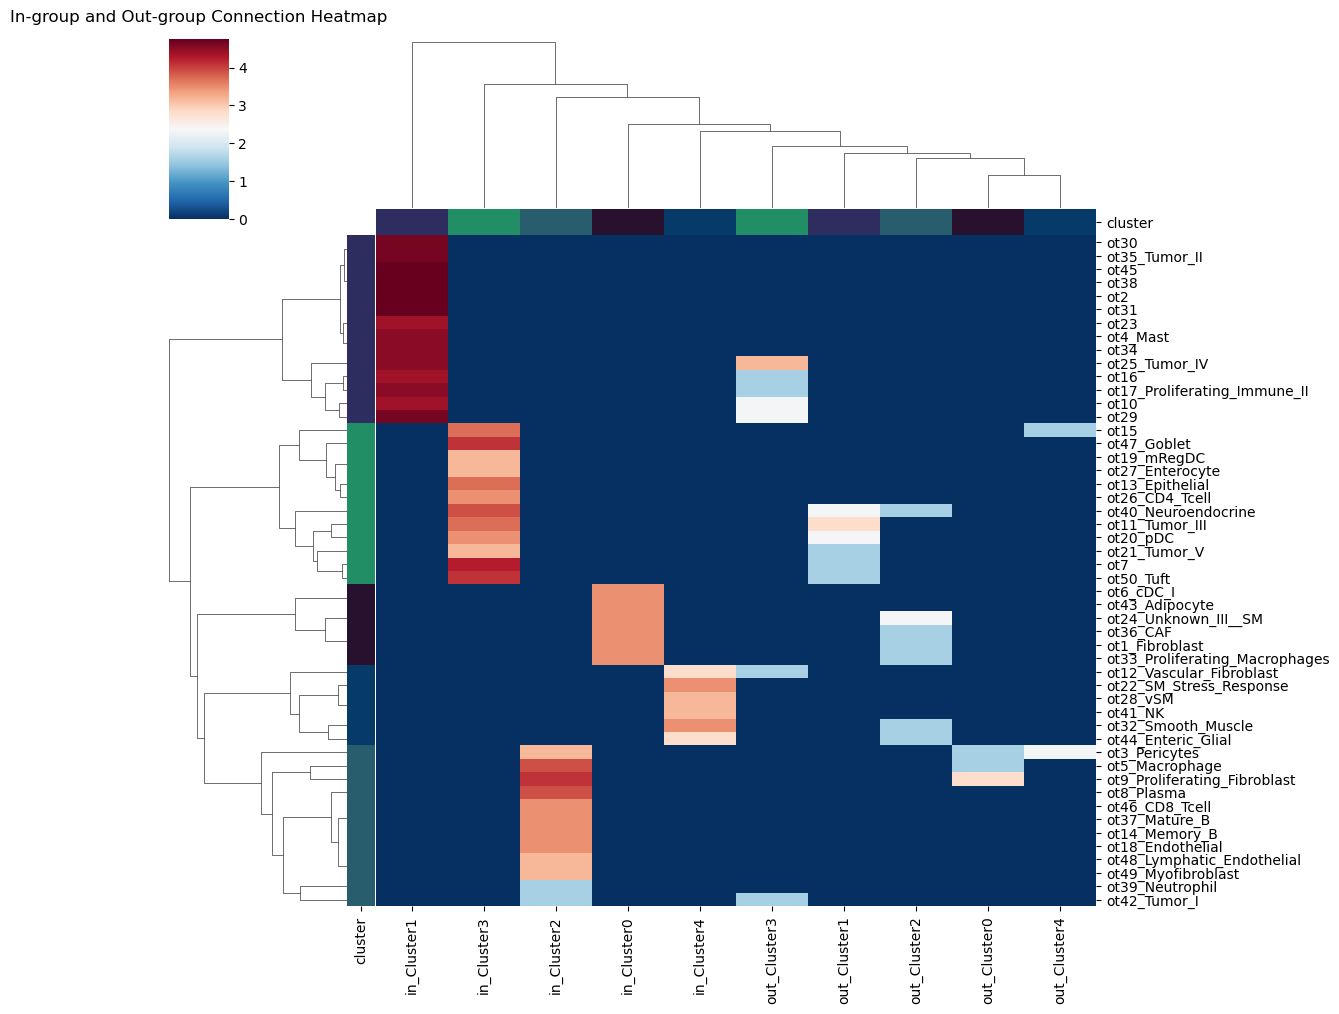

In [51]:
plot_connection_heatmap(group_connections,
                        rowannot=rowannot, columnannot=columnannot,
                        figsize=(12, 10), cmap="RdBu_r",
                        cluster_rows=True, cluster_cols=True)